In [63]:
#!conda update --all --yes
!conda install cudnn --yes
!pip install --upgrade pip
!pip install tensorflow-gpu
!pip install imutils
!pip install tqdm
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
!pip install --upgrade tensorflow-hub

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.3.1)
Requirement already up-to-date: tensorflow-hub in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.6.0)


In [64]:
#!mkdir data
#!curl https://ecs.victoria.ac.nz/foswiki/pub/Courses/COMP309_2019T2/Assignments/Train_data_2019.zip -o data/train.zip
#!unzip -o data/train.zip -d data

In [75]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import imageio
import random
import math
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tensorflow_hub as hub

make_dir = lambda path: os.path.exists(path) or os.makedirs(path)

In [76]:
epochs = 50
IMG_HEIGHT = 224 #300 
IMG_WIDTH = 224 # 300
train_pct = 0.8
batch_size = 24

In [77]:
random.seed(309)

make_dir('data/train')
make_dir('data/test')

for label_dir in glob.glob('data/Train_data/*'):    
    label = label_dir.split('/')[-1]
    make_dir(f'data/train/{label}')
    make_dir(f'data/test/{label}')
    
    images = glob.glob(f'{label_dir}/*')
    random.shuffle(images)
    
    split_index = math.floor(len(images) * train_pct)
    for i, image in enumerate(images):
        train_or_test = 'train' if i < split_index else 'test'
        new_path = image.replace('Train_data', train_or_test)
        
        shutil.move(image, new_path)

In [88]:
data_augmentation = dict(
    horizontal_flip=True,
    rotation_range=35,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=25,
    brightness_range=[0.75, 1.25],
)

train_data_gen = ImageDataGenerator(rescale=1.0/255, **data_augmentation).flow_from_directory(
    batch_size=batch_size,
    directory='data/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

# don't augment the test data in this case - maybe look into TTA
test_data_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    batch_size=batch_size,
    directory='data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
)

Found 3600 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


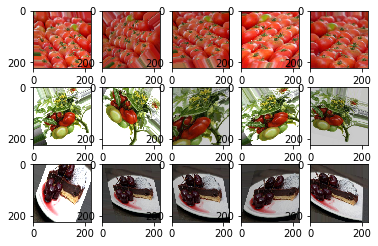

In [91]:
_, axes = plt.subplots(3, 5)

for image in range(axes.shape[0]):
    for example in tqdm(range(axes.shape[1])):
        axes[image,example].imshow(train_data_gen[0][0][image])

In [94]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # freeze the pre-trained bit

In [95]:
model = tf.keras.Sequential([
    base_model,
    #global_average_layer,
    #prediction_layer
    tf.keras.layers.AveragePooling2D(),
    Flatten(),
    Dropout(0.25),
    Dense(3, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [96]:
history = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    epochs=15,
)

Epoch 1/10
150/150 [==============================] - 83s 554ms/step - loss: 0.8878 - accuracy: 0.7394 - val_loss: 1.1494 - val_accuracy: 0.7356
Epoch 2/10
150/150 [==============================] - 82s 548ms/step - loss: 0.7599 - accuracy: 0.8089 - val_loss: 0.9336 - val_accuracy: 0.7856
Epoch 3/10
150/150 [==============================] - 80s 530ms/step - loss: 0.7534 - accuracy: 0.8206 - val_loss: 0.9322 - val_accuracy: 0.8022
Epoch 4/10
150/150 [==============================] - 81s 537ms/step - loss: 0.7986 - accuracy: 0.8214 - val_loss: 0.8573 - val_accuracy: 0.8267
Epoch 5/10
150/150 [==============================] - 80s 534ms/step - loss: 0.7934 - accuracy: 0.8297 - val_loss: 1.1596 - val_accuracy: 0.7767
Epoch 6/10
150/150 [==============================] - 81s 543ms/step - loss: 0.7601 - accuracy: 0.8389 - val_loss: 1.0110 - val_accuracy: 0.8333
Epoch 7/10
150/150 [==============================] - 83s 554ms/step - loss: 0.7786 - accuracy: 0.8392 - val_loss: 1.0863 - val_ac

In [97]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [98]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit_generator(
    train_data_gen,
    validation_data=test_data_gen,
    initial_epoch=15,
    epochs=30,
)

Epoch 6/15
150/150 [==============================] - 91s 610ms/step - loss: 0.7110 - accuracy: 0.8653 - val_loss: 1.1515 - val_accuracy: 0.8233
Epoch 7/15
150/150 [==============================] - 87s 580ms/step - loss: 0.6324 - accuracy: 0.8839 - val_loss: 1.0386 - val_accuracy: 0.8244
Epoch 8/15
150/150 [==============================] - 87s 581ms/step - loss: 0.5957 - accuracy: 0.8811 - val_loss: 1.0002 - val_accuracy: 0.8344
Epoch 9/15
150/150 [==============================] - 86s 573ms/step - loss: 0.6212 - accuracy: 0.8728 - val_loss: 1.0192 - val_accuracy: 0.8300
Epoch 10/15
150/150 [==============================] - 89s 595ms/step - loss: 0.5947 - accuracy: 0.8800 - val_loss: 0.9764 - val_accuracy: 0.8300
Epoch 11/15
150/150 [==============================] - 86s 574ms/step - loss: 0.5229 - accuracy: 0.8917 - val_loss: 1.0158 - val_accuracy: 0.8244
Epoch 12/15
150/150 [==============================] - 87s 580ms/step - loss: 0.5040 - accuracy: 0.8869 - val_loss: 0.9736 - val

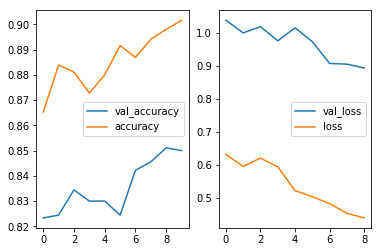

In [99]:
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.legend()

ax2.plot(history.history['val_loss'][1:], label='val_loss')
ax2.plot(history.history['loss'][1:], label='loss')
ax2.legend()